### finetuning tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [8]:
from transformers import AutoFeatureExtractor, DeiTForImageClassificationWithTeacher

# feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-tiny-distilled-patch16-224')

# model = DeiTForImageClassificationWithTeacher.from_pretrained('facebook/deit-tiny-distilled-patch16-224')

C:\Users\Jeremy\AppData\Local\Programs\Python\Python38\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\Jeremy\AppData\Local\Programs\Python\Python38\lib\site-packages\torchaudio\backend\utils.py:89: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [9]:
from transformers import DeiTFeatureExtractor, DeiTForImageClassification
# from PIL import Image
# import requests

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)
# # note: we are loading a DeiTForImageClassificationWithTeacher from the hub here,
# # so the head will be randomly initialized, hence the predictions will be random
# feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-tiny-distilled-patch16-224')
model = DeiTForImageClassification.from_pretrained('facebook/deit-tiny-distilled-patch16-224')
# inputs = feature_extractor(images=image, return_tensors="pt")
# outputs = model(**inputs)
# logits = outputs.logits
# # model predicts one of the 1000 ImageNet classes
# predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", model.config.id2label[predicted_class_idx])

Some weights of the model checkpoint at facebook/deit-tiny-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['cls_classifier.bias', 'distillation_classifier.bias', 'distillation_classifier.weight', 'cls_classifier.weight']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream t

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [11]:
# Data augmentation and normalization for training
# Just normalization for validation
train_folder_name = "train"
test_folder_name = "test"

data_transforms = {
    train_folder_name: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    test_folder_name: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
    for x in [train_folder_name, test_folder_name]
} 
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in [train_folder_name, test_folder_name]
}
dataset_sizes = {x: len(image_datasets[x]) for x in [train_folder_name, test_folder_name]}
class_names = image_datasets[train_folder_name].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

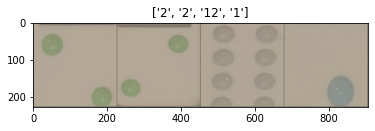

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders[train_folder_name]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs.logits, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # outputs, logits = model(inputs)                    
                    outputs = model(inputs)
                    # print(outputs.logits)
                    _, preds = torch.max(outputs.logits, 1)
                    loss = criterion(outputs.logits, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 13)
model = model.to(device)

In [16]:
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)

# model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
model = train_model(
    model, 
    criterion, 
    optimizer_ft, 
    exp_lr_scheduler,
    num_epochs=10,
)

Epoch 0/9
----------
train Loss: 3.0484 Acc: 0.0000
test Loss: 2.5229 Acc: 0.0769

Epoch 1/9
----------
train Loss: 2.5864 Acc: 0.1538
test Loss: 2.2749 Acc: 0.3077

Epoch 2/9
----------
train Loss: 2.3891 Acc: 0.3077
test Loss: 1.9939 Acc: 0.3846

Epoch 3/9
----------
train Loss: 2.4123 Acc: 0.2308
test Loss: 1.6839 Acc: 0.4615

Epoch 4/9
----------
train Loss: 2.1290 Acc: 0.1923
test Loss: 1.6685 Acc: 0.5385

Epoch 5/9
----------
train Loss: 1.9970 Acc: 0.2308
test Loss: 1.7927 Acc: 0.3846

Epoch 6/9
----------
train Loss: 1.7878 Acc: 0.2692
test Loss: 0.9336 Acc: 0.6923

Epoch 7/9
----------
train Loss: 0.9955 Acc: 0.6923
test Loss: 0.7269 Acc: 0.8462

Epoch 8/9
----------
train Loss: 0.8927 Acc: 0.8077
test Loss: 0.6037 Acc: 0.9231

Epoch 9/9
----------
train Loss: 0.8141 Acc: 0.8077
test Loss: 0.5065 Acc: 0.9231

Training complete in 0m 57s
Best test Acc: 0.923077


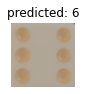

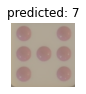

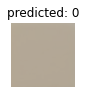

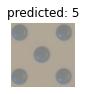

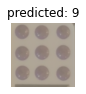

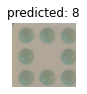

In [19]:
visualize_model(model)

### Saving pytorch model

In [20]:
torch.save(model.state_dict(), "dominoes_torch.pkl")

### loading pytorch model

In [21]:
model.load_state_dict(torch.load("dominoes_torch.pkl"))
model.eval()

DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0): DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=19

## Exporting of onnx models

In [22]:
# Input to the model
batch_size = 1
x = torch.randn(batch_size, 3, 224, 224, requires_grad=True)
torch_out = model(x)

# Export the model
torch.onnx.export(
    model,               # model being run
    x,                         # model input (or a tuple for multiple inputs)
    "domino_model.onnx",   # where to save the model (can be a file or file-like object)
    export_params=True,        # store the trained parameter weights inside the model file
    opset_version=13,          # the ONNX version to export the model to
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names = ['input'],   # the model's input names
    output_names = ['output'], # the model's output names
    dynamic_axes={
        'input' : {0 : 'batch_size'},    # variable length axes
        'output' : {0 : 'batch_size'}
    })

C:\Users\Jeremy\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\models\deit\modeling_deit.py:116: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


In [27]:
torch_out.logits

tensor([[ 2.2752,  0.0153, -0.0647, -0.6364,  0.9701,  0.8948, -0.3297, -0.2033,
         -1.4723,  1.6785, -0.8921, -0.8584,  0.1483]],
       grad_fn=<AddmmBackward>)

In [31]:
import onnx

onnx_model = onnx.load("domino_model.onnx")
print(onnx.checker.check_model(onnx_model))

None


In [24]:
import onnx
from onnxruntime.quantization import quantize_qat, QuantType

model_fp32 = 'domino_model.onnx'
model_quant = 'domino_model.quant.onnx'
quantized_model = quantize_qat(model_fp32, model_quant)

In [32]:
import onnxruntime

ort_session = onnxruntime.InferenceSession('domino_model.quant.onnx')

def to_numpy(tensor):
    # return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
    return tensor.detach().cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out.logits), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 13 / 13 (100%)
Max absolute difference: 0.21925117
Max relative difference: 1.9849129
 x: array([[ 2.275169,  0.015318, -0.064712, -0.636433,  0.970129,  0.894817,
        -0.32971 , -0.203276, -1.472253,  1.67851 , -0.892069, -0.858431,
         0.148315]], dtype=float32)
 y: array([[ 2.270078, -0.133312, -0.105959, -0.644246,  0.994942,  0.935984,
        -0.110459, -0.120364, -1.38856 ,  1.535124, -0.938352, -0.793073,
         0.131251]], dtype=float32)

In [3]:
!python -m nnef_tools.convert --input-format onnx --output-format nnef --input-model domino_model.onnx

Input graph contains tensors with unknown shape: '213', '214', '232', '250', '251', '252', '253', '254', '256', '257', '259', '260', '261', '262', '263', '265', '266', '268', '269', '287', '289', '290', '308', '309', '327', '328', '329', '330', '332', '333', '334', '335', '350', '352', '353', '354', '355', '356', '358', '359', '361', '362', '363', '364', '365', '367', '368', '370', '371', '373', '374', '376', '378', '379', '380', '381', '382', '384', '385', '387', '388', '389', '390', '391', '393', '394', '396', '397', '415', '417', '418', '436', '437', '455', '456', '457', '458', '460', '461', '462', '463', '478', '480', '481', '482', '483', '484', '486', '487', '489', '490', '491', '492', '493', '495', '496', '498', '499', '501', '502', '504', '506', '507', '508', '509', '510', '512', '513', '515', '516', '517', '518', '519', '521', '522', '524', '525', '543', '545', '546', '564', '565', '583', '584', '585', '586', '588', '589', '590', '591', '606', '608', '609', '610', '611', '612',

In [35]:
pip install future typing six numpy protobuf onnx onnx-simplifier onnxruntime

  Using cached future-0.18.2.tar.gz (829 kB)
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=152cd66c849df31ef44903fa4f6d913a46328a2147d551e8acc898c263a6ba28
  Stored in directory: c:\users\jeremy\appdata\local\pip\cache\wheels\8e\70\28\3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26308 sha256=d72d926c83b60dbefe054b3e3e64ad25480fd128bdf24c1e17ff4b3b0f242350
  Stored in directory: c:\users\jeremy\appdata\local\pip\cache\wheels\5e\5d\01\3083e091b57809dad979ea543def62d9d878950e3e74f0c930
  Created wheel for onnx-simplifier: filename=onnx_simplifier-0.3.5-py3-none-any.whl size=12863 sha256=3305ab7815683fb8f90271df3eeec9759c6af5a3aa0295a7ce3fa9c917fa71e0
  Stored in directory: c:\users\jeremy\appdata\local\pip\cache\wheels\67\41\4b\ab44ea796416a698b22f1445154937a23e2b867211b25d16f5
Successfully built future typing onnx-simplifier
Note: you may need to restart the kernel to 